# Molecular Interaction: Temporal Dominant Regulatory Interactions

To obtain mechanistic insights into key regulatory motifs from different perspectives, we developed three complementary strategies: cell-wise, trajectory-wise and plane-wise analyses. In this tutorial, we will introduce approaches for gene network motif analysis and guide you to perform cell-wise analyses of SPI1-GATA1 network motif.

Import relevant packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style(font_path='Arial')
dyn.get_all_dependencies_version()

%load_ext autoreload
%autoreload 2

Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,requests,pynndescent,pre-commit,pandas,openpyxl,numdifftools,numba,networkx,mudata,matplotlib,loompy,leidenalg,igraph,dynamo-release,colorcet,anndata
version,0.5.7,4.13.2,4.67.1,0.14.4,79.0.0,1.0.1,0.13.2,1.11.4,2.32.3,0.5.13,4.2.0,2.2.3,3.1.5,0.9.41,0.60.0,3.4.2,0.3.1,3.10.3,3.0.8,0.10.2,0.11.8,1.4.2rc1,3.1.0,0.11.4


In [2]:
adata_labeling = dyn.sample_data.hematopoiesis()

|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad
|-----> File ./data/hematopoiesis.h5ad already exists.


## Three approaches for in-depth network motif characterizations
The schematic graph in this section shows the three approaches.
- cell-wise analyses to reveal dominant interactions across all cells
- trajectory-wise analyses reveal trajectory dependent interactions along a trajectory (predicted either from vector field streamline, or least action path, see Figure 6). 
- Plane-wise analyses reveal direct interactions for any characteristic cell states by varying genes of interest while holding all other genes constant.

In the next section, we will use **cell-wise analyses** to analyze PU.1/SPI1–GATA1 network motif.  

![fig5_h](images/fig5_h.png)

## Cell-wise analyses of the PU.1/SPI1–GATA1 network motif across all cells

We showcase cell-wise analyses with the canonical PU.1/SPI1-GATA1 network motif.

### Streamline plot of the RNA velocities of SPI1 (x-axis) and GATA1 (y-axis)

The streamlines of SPI1 and GATA1 show that HSPCs bifurcate into GMP-like and MEP-like branches

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


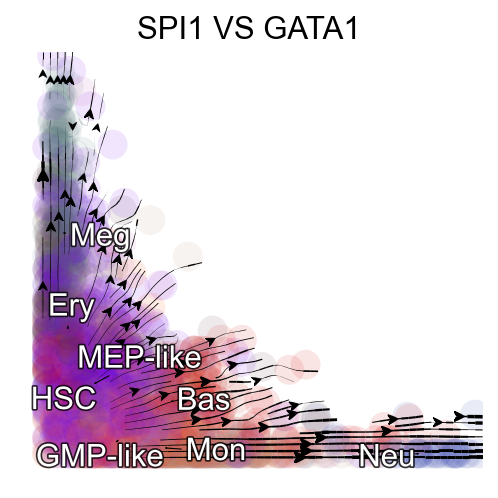

In [4]:
#dyn.configuration.set_pub_style(scaler=4)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, nrows=1, 
                       constrained_layout=True, 
                       figsize=(3, 3))
ax=dyn.pl.streamline_plot(
    adata_labeling,
    color="cell_type",
    x="SPI1",
    y="GATA1",
    layer="M_t",
    ekey="M_t",
    pointsize=0.5,
    ax=ax,
    vkey="velocity_alpha_minus_gamma_s",
    save_show_or_return='return',
    s_kwargs_dict={'adjust_legend':True,'dpi':80,
                  'arrow':False},
)


Next we will use jacobian to show
- Repression from SPI1 to GATA1, GATA1 to SPI1
- self-activation of SPI1, and GATA1, in the SPI1 and GATA1 expression space

In particular, the repression from SPI1 to GATA1 is mostly discernable in progenitors (rectangle A: bottom left) but becomes negligible when either GATA1 is much higher than SPI1 (rectangle B: upper left) or GATA1 is close to zero (rectangle C: bottom right).

Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 97935.00it/s]

|-----------> plotting with basis key=X_umap



Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 103537.46it/s]

|-----------> plotting with basis key=X_umap



calculating Jacobian for each cell: 100%|██████████| 1947/1947 [00:00<00:00, 124663.16it/s]


|-----------> plotting with basis key=X_umap


calculating Jacobian for each cell: 100%|██████████| 1947/1947 [00:00<00:00, 122770.27it/s]

|-----------> plotting with basis key=X_umap


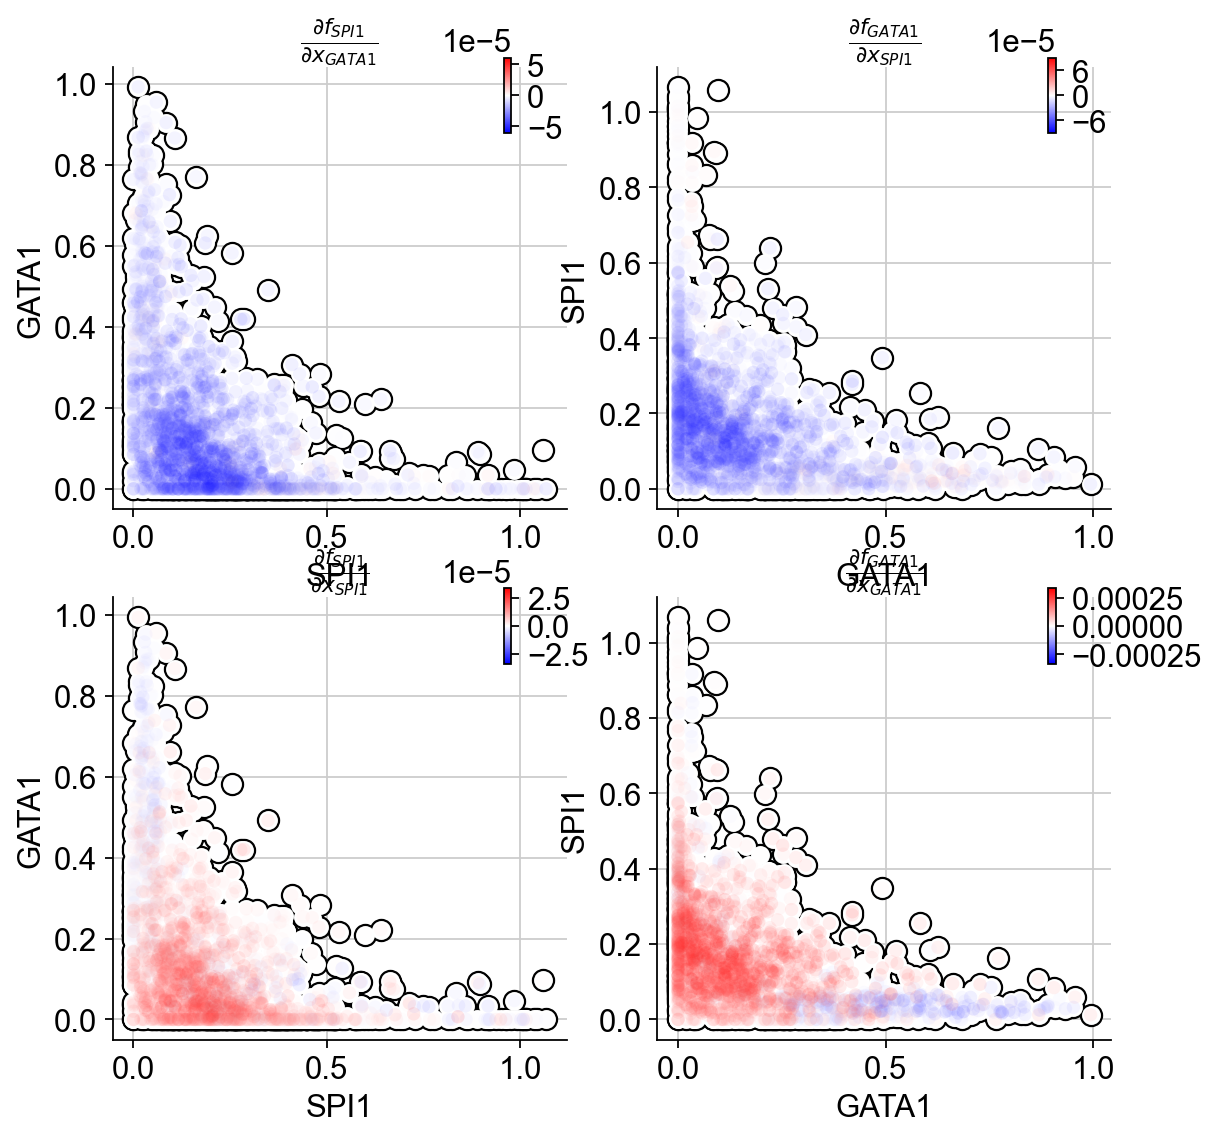

In [10]:
%matplotlib inline
import numpy as np
genes = ["SPI1", "GATA1"]
def plot_jacobian_on_gene_axis(receptor, effector, x_gene=None, y_gene=None, axis_layer="M_t", temp_color_key="temp_jacobian_color", ax=None):
    if x_gene is None:
        x_gene = receptor
    if y_gene is None:
        y_gene = effector

    x_axis = adata_labeling[:, x_gene].layers[axis_layer].A.flatten(),
    y_axis = adata_labeling[:, y_gene].layers[axis_layer].A.flatten(),

    dyn.vf.jacobian(adata_labeling, regulators = [receptor, effector], effectors=[receptor, effector])
    J_df = dyn.vf.get_jacobian(
        adata_labeling,
        receptor,
        effector,
    )
    color_values = np.full(adata_labeling.n_obs, fill_value=np.nan)
    color_values[adata_labeling.obs["pass_basic_filter"]] =  J_df.iloc[:, 0]
    adata_labeling.obs[temp_color_key] = color_values

    ax = dyn.pl.scatters(
        adata_labeling,
        vmin=0,
        vmax=100,
        color=temp_color_key,
        cmap="bwr",
        sym_c=True,
        frontier=True,
        sort="abs",
        alpha=0.1,
        pointsize=0.1,
        x=x_axis,
        y=y_axis,
        save_show_or_return="return",
        despline=True,
        despline_sides=["right", "top"],
        deaxis=False,
        ax=ax,
        arrow=False,
    )
    ax.set_title(r"$\frac{\partial f_{%s}}{\partial x_{%s}}$" % (effector, receptor))
    ax.set_xlabel(x_gene)
    ax.set_ylabel(y_gene)
    adata_labeling.obs.pop(temp_color_key)

figure, axes = plt.subplots(2, 2, figsize=(8, 8))
plot_jacobian_on_gene_axis("GATA1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[0,0])
plot_jacobian_on_gene_axis("SPI1", "GATA1", x_gene="GATA1", y_gene="SPI1", ax=axes[0,1])
plot_jacobian_on_gene_axis("SPI1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[1,0])
plot_jacobian_on_gene_axis("GATA1", "GATA1", x_gene="GATA1", y_gene="SPI1",ax=axes[1,1])


The streamlines of SPI1 and GATA1 in UMAP space and colored by `M_t` show that HSPCs bifurcate into GMP-like and MEP-like branches clearly.

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


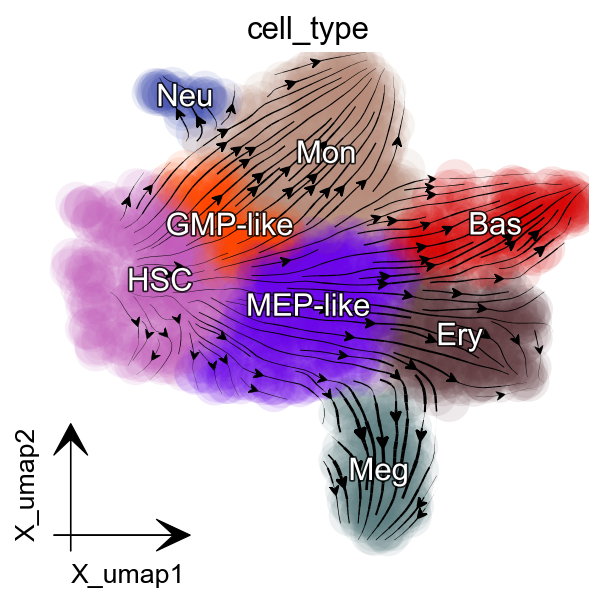

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


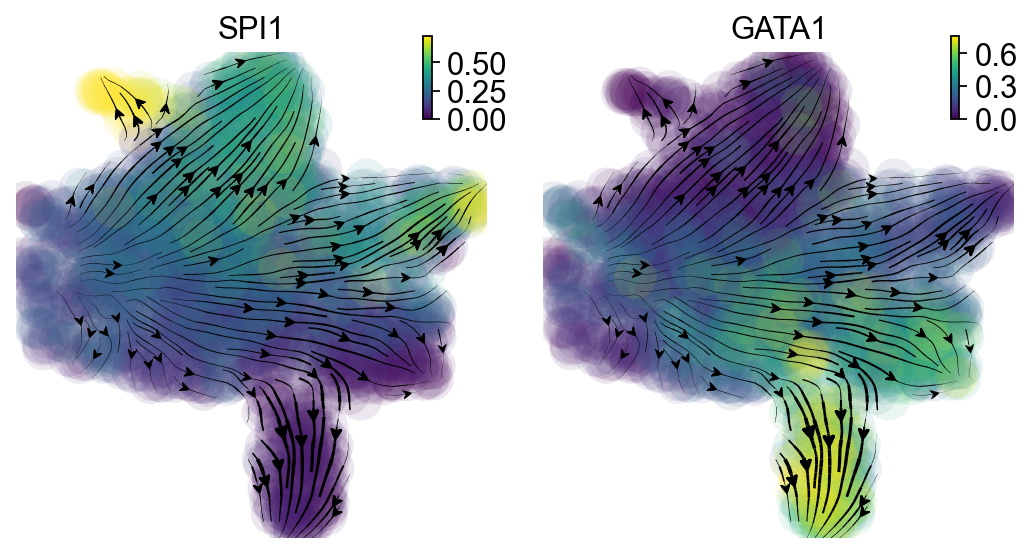

In [13]:
dyn.pl.streamline_plot(
    adata_labeling,
    color=["cell_type"],
    layer="M_t",
    figsize=(4, 4),
    ncols=2
)

dyn.pl.streamline_plot(
    adata_labeling,
    color=["SPI1", "GATA1"],
    layer="M_t",
    figsize=(4, 4),
    ncols=2,
    s_kwargs_dict={'adjust_legend':True,'dpi':80,
                  'arrow':False},
)

UMAP jacobian analysis reveals self-activation of SPI1 in GMP and GATA1 in MEP, and mutual inhibition of SPI1 and GATA1 in GMP and MEP.

Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 71364.49it/s]


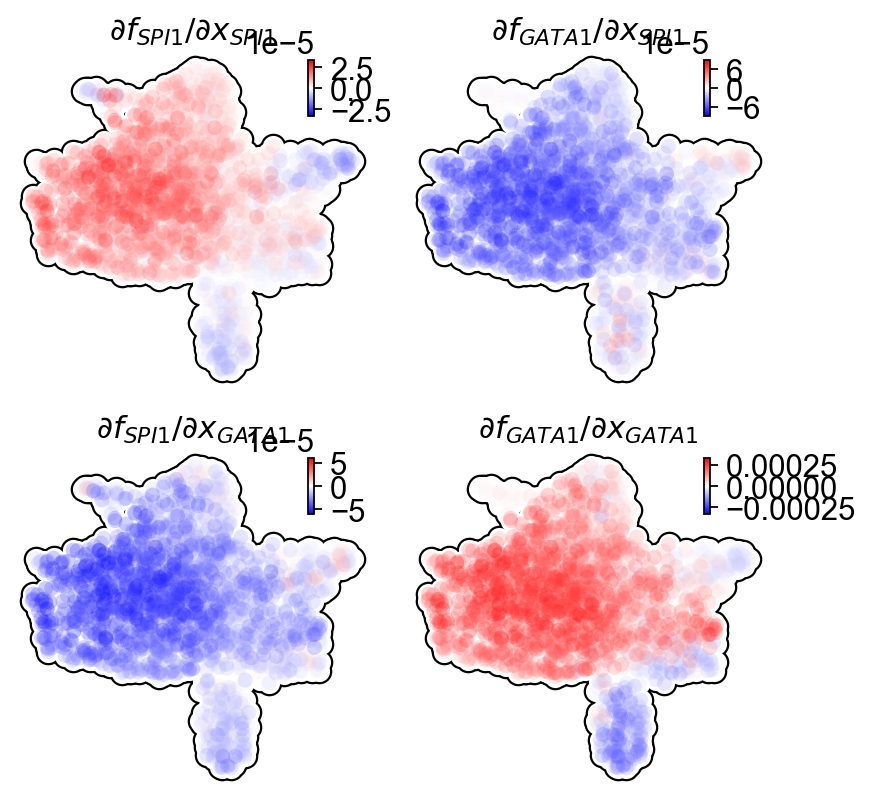

In [14]:
dyn.vf.jacobian(adata_labeling,
                regulators = ["SPI1", "GATA1"])
dyn.pl.jacobian(adata_labeling, figsize=(3,3),
                regulators = ["SPI1", "GATA1"])

### Response heatmap
White dashed lines indicate the minimum or maximum of repression or activation and the corresponding expression threshold.

Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 101163.35it/s]


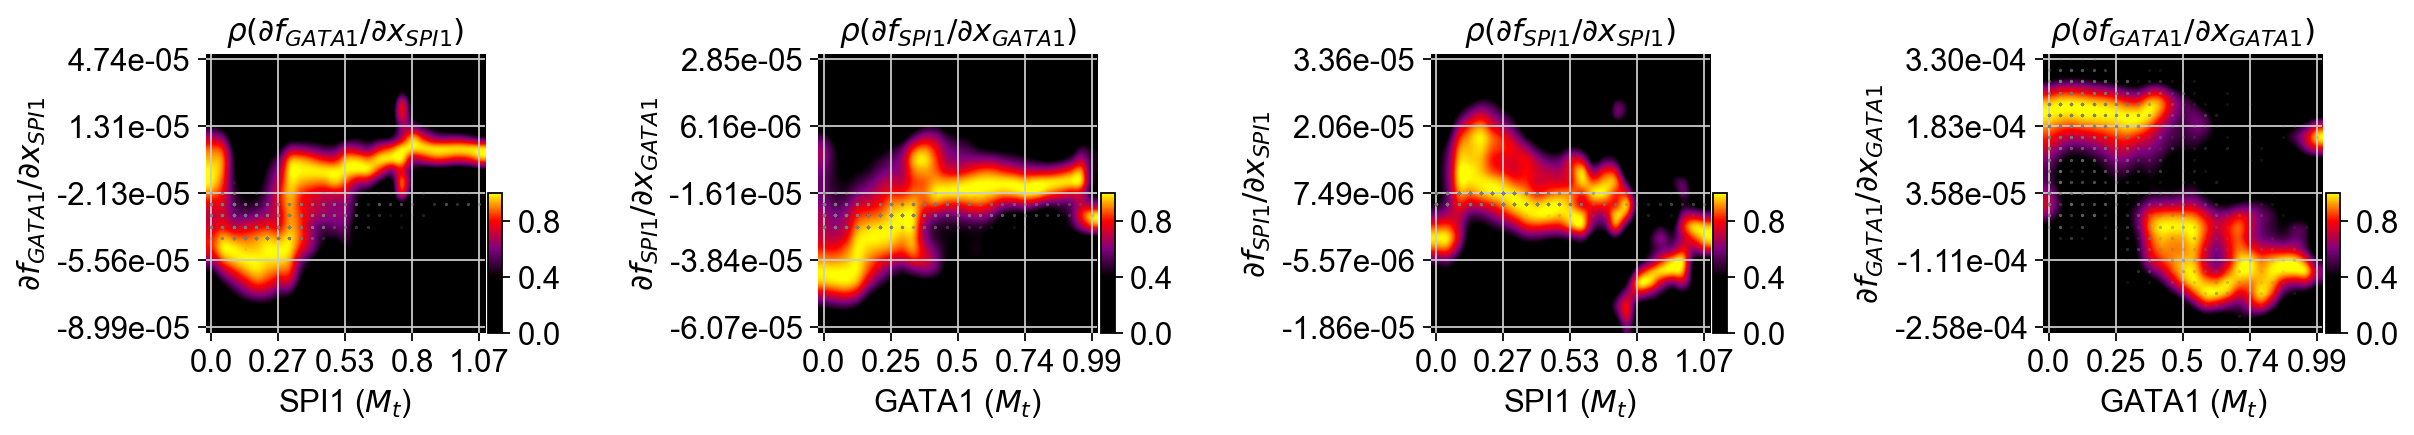

In [16]:
%matplotlib inline

dyn.vf.jacobian(adata_labeling, regulators=["SPI1", "GATA1"], 
                effectors=["SPI1", "GATA1"])
dyn.pl.response(
    adata_labeling,
    np.array([["SPI1", "GATA1"], ["GATA1", "SPI1"], 
              ["SPI1", "SPI1"], ["GATA1", "GATA1"]]),
    ykey="jacobian",
    log=False,
    drop_zero_cells=True,
    grid_num=25,
    figsize=(4, 3),
    save_show_or_return="show"
)

## Conclusion

In the analyses above, we illustrate how to use `dynamo` to perform cell-wise analysis to explore the canonical PU.1/SPI1-GATA1 network motif. A schematic diagram of the SPI1-GATA1 toggle switch model can be summarized below.

![fig5_I_i](images/fig5_I_i.png)